# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scripts.util import *
from scripts.builders import *

## Atributos

Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - ¿Tiene el mail contenido HTML?
    - ¿Tiene el mail imágenes?
2. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
3. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
4. Análisis de sentimiento.

Para los atributos 2 y 3, se utilizó TfIdfVectorizer de scikit-learn.

Para el análisis de sentimientos, se extrajo de cada oración (de cada cuerpo) los valores de negatividad, neutralidad y positividad resultantes de la herramienta Vader de NLTK y se calculó la media para estos.


Un primer análisis sobre la utilización de estos atributos resaltó un gran tiempo de ejecución alto para la extracción de información sobre sentimientos. También vimos que no parecían mejorar la calidad de los modelos, por lo tanto decidimos removerlos del conjunto de atributos con los que experimentar.

## Reducción de dimensionalidad

Probaremos usando tres técnicas de selección de atributos:
    1. Elegir los N atributos (20 para el sujeto y 50 para el cuerpo) que son más probables (según un test chi2) que sean dependientes de la etiqueta
    2. Entrenar un clasificador SVM lineal con penalización L1 (fuerza esparcidad, gran cantidad de pesos en 0), 
        y elegir los atributos que más importancia tengan para este clasificador
    3. Análisis de Componentes Principales para reducción de dimensionalidad (misma cantidad de atributos que 1)
    
## Modelos

Los algoritmos de aprendizaje automático elegidos fueron los siguientes:
- Árboles de decisiones
- Bosques aleatorios (Random forests)
- Naive Bayes
    - Bernoulli
    - Multinomial
- K vecinos más cercanos (KNN)
- Máquinas de vectores de soporte (SVM)

## Prueba de sanidad

Para no invertir tiempo entrenando modelos que no tengan buena performance, realizamos una prueba de sanidad, realizando el mismo procedimiento que sera descrito en la sección siguiente, pero corriendolo sobre un subconjunto de 10000 instancias de entrenamiento. Para ver mas detalles, se puede consultar el notebook **sanidad**.

Las conclusiones obtenidas fueron:
- SVM insume una cantidad de tiempo significativamente mayor que el resto de los clasificadores, y tiene una performance muy significativamente menor. Es por esto que en las pruebas aquí presentes, lo excluímos.
- KNN y Naive Bayes Multinomial presentaron en media (sobre las distintas posibles elecciones de extracción y selección de atributos) un rendimiento también menor que el de los otros clasificadores, pero al mismo tiempo una gran varianza. Inspeccionando en detalle, se descubrió que la presencia de los atributos simples perjudicaba mucho a estos algoritmos, por lo que se decidio incluirlos aquí considerando únicamente las variantes que no tuvieran los atributos simples.

## Disclaimers

- Si bien en base a las pruebas de sanidad decidimos incluir KNN, al momento de correrlo con el set de entrenamiento completo, se presentó un problema: al momento de hacer el fitteo, el algoritmo tiene un pico de consumo de memoria (en algunos casos superior a varios GB). Esto provocó que en algunos equipos no se pueda correr, y que en los que era posible, no se pudiera paralelizar el CV, lo que insumía muchisimo tiempo (varias horas por cada uno) y nos retrasaba muchisimo en la experimentación. Es por esto que terminamos decidiendo removerlo de la lista de clasificadores a probar

- Los parámetros utilizados para los distintos componentes del modelo fueron elegidos manualmente, realizando pequeñas pruebas y eligiendo los mejores. Sabemos que lo correcto hubiera sido incluirlos en la experimentación que hacemos a continuación, por medio de un GridSearchCV, pero también por pruebas que hicimos inicialmente, nos encontramos con una explosión combinatoria de la cantidad de fitteos a realizar, lo que hacía que fuese imposible realizar la experimentacion (en algun punto hicimos la cuenta, y nos iba a llevar varios meses de corrida).
Para los clasificadores, los valores por defecto de scikit-learn probaron conseguir muy buenos resultados, por lo que estos seran los que utilizemos

## Experimentación sobre los modelos
### Carga de datos

Se separa inicialmente un conjunto de entrenamiento y de test, con el objetivo de poder brindar información sobre el rendimiento del clasificador elegido como el mejor para la tarea. El conjunto de test corresponde al 20% de todo el dataset.

Todos los mails son parseados utilizando el módulo email de Python.

Los mails que contienen código HTML son también parseados, utilizando el módulo HTMLParser, para la remoción del código HTML, dejando sólo el texto.

In [3]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 0.915000s

Loading Test Set
Done in 0.235000s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


### Experimentación sobre modelos

Con el objetivo de analizar el comportamiento de los diferentes modelos, se construye uno para cada una de las siguientes variaciones:
- Se realiza (o no) la extracción los atributos simples
- Se incluye (o no) la matriz (TF-IDF) del sujeto
- Se incluye (o no) la matriz (TF-IDF) del cuerpo
- Tipo de clasificador (DT, RF, NBB, NBM)

Para los atributos TF-IDF tanto del sujeto como del cuerpo, se varía sobre la utilización de los algoritmos K Best, SVM lineal con penalización L1 y PCA para la reducción de dimensionalidad de los mismos.

Para cada uno de los modelos armados (con todas las variaciones mencionadas), corremos un 10-Fold CV sobre el conjunto de entrenamiento, obteniendo la media y la varianza de los resultados del CV (exactitud), y el tiempo requerido para correrlo.


In [4]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb', 'multinomial_nb']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)
pipelines = [(name, configuration, pipeline) for 
             name, configuration, pipeline in pipelines if 
             not (configuration['simple_features'] and configuration['classifier_type'] == 'multinomial_nb')]

In [5]:
scores, cv_times = evaluate_and_measure(train_set, pipelines, 'full', cv=10, n_jobs=5)

Loading scores from results/full_scores.pkl
Done in 0.003000s
Loading cv_times from results/full_cv_times.pkl
Done in 0.000000s



### Visualización de los resultados

Visualizaremos los resultados de cada clasificador mediante boxplots. Como multinomial_nb no tiene simple_features, nos pareció lo mas adecuado mostar los resultados por clasificador y presencia de los simple_features, para evitar sesgos.

In [6]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]

    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [7]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

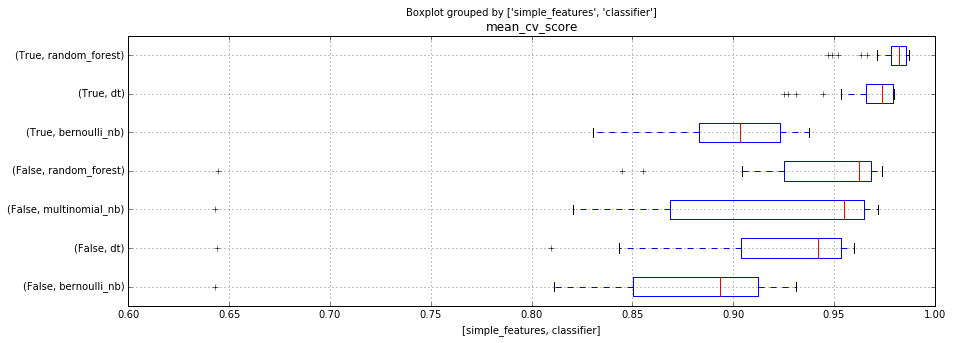

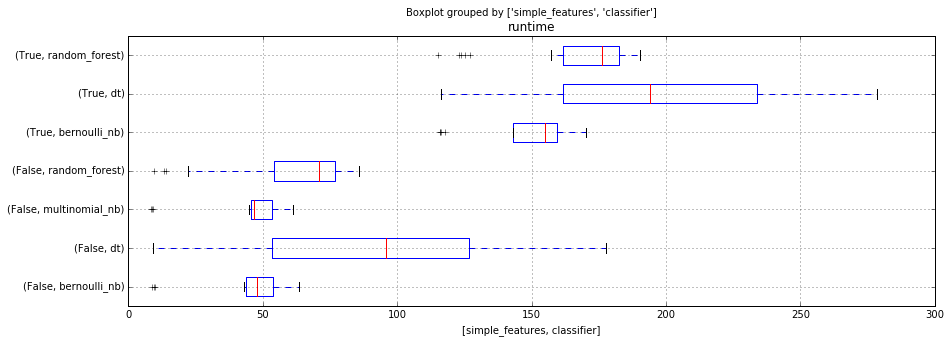

In [8]:
summary_df.boxplot(column=['mean_cv_score'], by=['simple_features', 'classifier'], vert=False)
summary_df.boxplot(column=['runtime'], by=['simple_features', 'classifier'], vert=False)

## Búsqueda y evaluación del mejor modelo

Para la elección del mejor modelo, calculamos la media de los valores de la exactitud reportados por cada clasificador.

Con el objetivo de simular el comportamiento del modelo elegido sobre nuevos datos, utilizamos el conjunto de testing para realizar una evaluación del modelo mediante Cross Validation.

In [9]:
mean_scores_list = [(name, np.mean(model_scores)) for name, model_scores in scores.iteritems()]
mean_scores_list[np.argmax(map(lambda x: x[1], mean_scores_list))]

('simple_features__subject_tfidf__body_l1__random_forest', 0.98698605694497932)

El modelo con mayor exactitud fue utilizando el algoritmo de clasificación de Bosques Aleatorios (RF) con:
- El conjunto de atributos simples descripto anteriormente.
- Atributos TF-IDF para el sujeto
- Atributos TF-IDF para el cuerpo, con reducción de dimencionalidad aplicando SVM con penalización L1.

Este modelo obtuvo una exactitud media de 0.986986 en la experimentación con CV, y será el modelo que elegimos para la competencia.
A continuación, veremos cómo se desempeña con el conjunto de testing.

In [10]:
best_model_name, _, best_model = build_pipeline(True, 'tfidf', 'l1', 'random_forest')

In [11]:
def model_evaluation(pipeline, name, X_train, X_test):
    print 'Training pipeline %s in the train set' % name
    print_time(lambda: pipeline.fit(X_train, X_train.label))
    print ''
    
    print 'Classifying test set with pipeline %s' % name
    pred = print_time(lambda: pipeline.predict(X_test))
    print ''

    print 'Accuracy: %f' % accuracy_score(X_test.label, pred)
    print ''
    
    print 'Classification report:'
    print classification_report(X_test.label, pred, target_names=['ham', 'spam'])
    print 'Confusion matrix:'
    print pd.crosstab(X_test.label, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [12]:
model_evaluation(best_model, best_model_name, train_set, test_set)

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the train set
Done in 68.279000s

Classifying test set with pipeline simple_features__subject_tfidf__body_l1__random_forest
Done in 14.071000s

Accuracy: 0.986278

Classification report:
             precision    recall  f1-score   support

        ham       0.98      0.99      0.99      9003
       spam       0.99      0.98      0.99      8997

avg / total       0.99      0.99      0.99     18000

Confusion matrix:
Predicted   ham  spam    All
True                        
ham        8907    96   9003
spam        151  8846   8997
All        9058  8942  18000


Podemos notar que la exactitud obtenida (0.986278) es muy similar a la obtenida media de CV sobre los datos de entrenamiento (0.986986).

Guardamos el modelo para utilizarlo posteriormente en un programa separado

In [13]:
print 'Training pipeline %s in the full dataset' % best_model_name
_ = print_time(lambda: best_model.fit(train_set.append(test_set), train_set.append(test_set).label))

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the full dataset
Done in 89.577000s


In [14]:
save_model('best_model', 'results', best_model)

Saving model best_model to disk
Done in 3.017000s
Saved at results/best_model.pkl


## Exploración de atributos mas importantes

A continuación graficamos histogramas para cada una de los 10 features mas importantes(extraidos en el set de entrenamiento), agrupando por la clase del mail correspondiente.

In [20]:
extractors = best_model.named_steps['feature_extractors']
simple_extractors = extractors.transformer_list[0][1]
subject_extractors = extractors.transformer_list[1][1]
subject_tfidf = subject_extractors.named_steps['tfidf']
body_extractors = extractors.transformer_list[2][1]
body_tfidf = body_extractors.named_steps['tfidf']
body_l1 = body_extractors.named_steps['l1']
rf = best_model.named_steps['random_forest']

feature_names = []
feature_names += [ 'simple features: ' + name  for name in simple_extractors.get_feature_names() ]
feature_names += [ 'subject tfidf: ' + name  for name in subject_tfidf.get_feature_names() ]
feature_names += [ 'body tfidf: ' + name  for name in body_l1.transform([body_tfidf.get_feature_names()])[0] ]
feature_names = np.asarray(feature_names)

In [21]:
extracted = extractors.transform(train_set)

In [22]:
top_features_indexs = np.argsort(rf.feature_importances_)[::-1][0:10]
top_features_importances = rf.feature_importances_[top_features_indexs]
top_feature_names = feature_names[top_features_indexs]
top_features = pd.DataFrame(extracted[:, top_features_indexs].todense(), columns=top_feature_names)
top_features['label'] = train_set.label

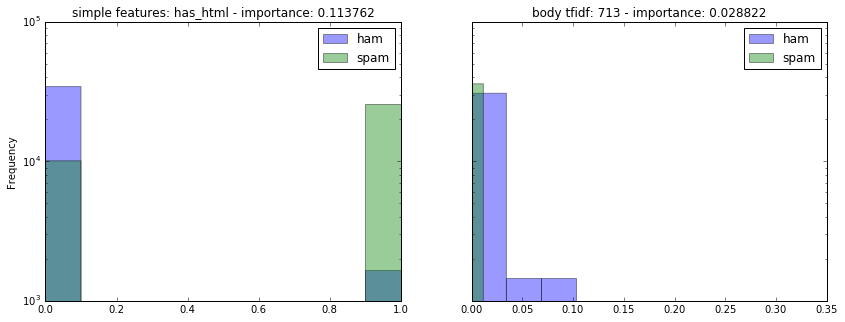

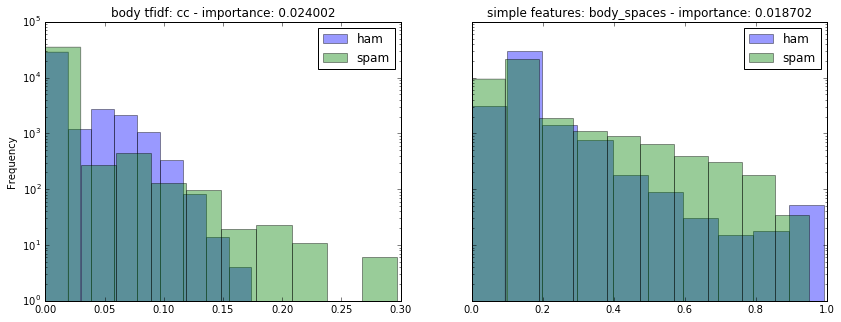

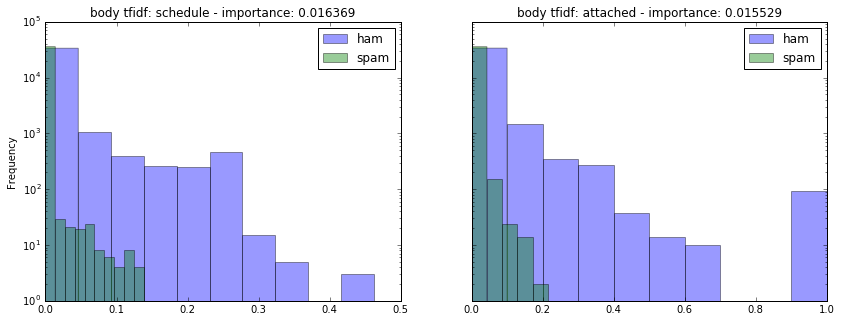

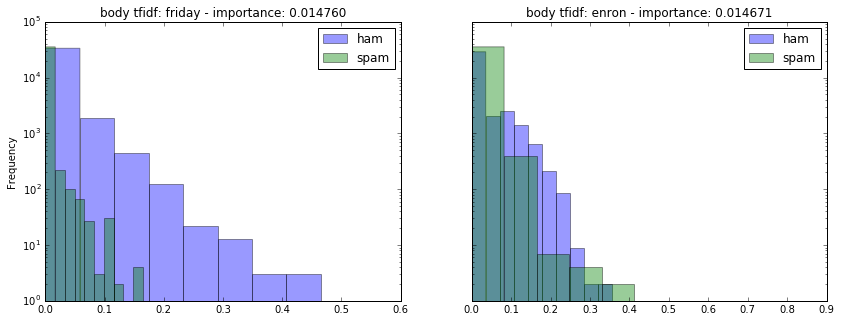

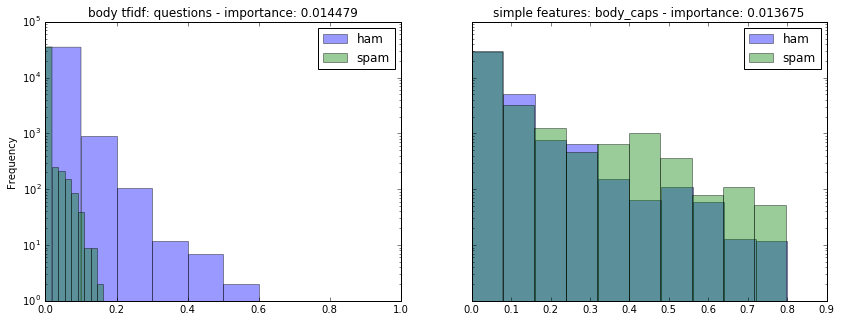

In [24]:
for i in range(10):
    if i % 2 == 0:
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    top_features.groupby('label')[top_feature_names[i]].plot(kind='hist',
                                            title=top_feature_names[i] + ' - importance: %f' % top_features_importances[i],
                                            ax=axs[i % 2],
                                            legend=True, alpha=0.4)

Como lo supusimos en la exploración, el hecho de contener o no HTML es el atributo que más sirve para discriminar la clase de los mails.

Las palabras '713', 'cc', 'schedule', 'attached', 'friday', 'enron' y 'questions' fueron las más relevantes a la hora de hacer esta misma discriminación. Notamos que todas estas palabras provienen del cuerpo del mail, no estando presente ninguna del sujeto. Creemos que de todas maneras el sujeto aporta a la clasificación, dado que sino este no sería el mejor modelo de todos.

La cantidad de espacios y mayúsculas resultaron también importantes en la decisión de clasificación.

Nos sorprende el segundo atributo más importante, la cantidad de apariciones de '713'. Una explicación posible sería alguna clase de sesgo en los datos.
Enron también parece algo extraño, pero es el nombre una empresa Americana de energía, y es de donde proviene el dataset.

Así como surgió en el notebook de **exploración**, el atributo la cantidad de apariciones de 'attached' esta entre los 10 atributos más importantes. 

## Conclusiones

- La primera (y gran) conclusión que nos llevamos de este trabajo, es que realizar experimentaciones de este tipo requiere una gran cantidad de recursos computacionales, causados por la inmensa cantidad de casos posibles que se pueden generar (tanto por usar GridSearch para los parámetros, como para elegir las mejores combinaciones de algoritmos.
- Es de suma importancia realizar pruebas preliminares (sobre todo cuando se cuenta con datasets tan masivos), ya que en un principio nos pusimos a hacer la experimentación sobre todos los datos, y perdimos una buena cantidad de tiempo causado por los problemas ya mencionados.
- También es muy importante explorar los datos y adentrarse en los resultados. Como ejemplo concreto, en un principio creímos que MultinomialNB y KNN simplemente no funcionaban bien para este caso; luego, cuando se nos ocurrió entrar en detalle del porqué de esto, vimos que el problema era en realidad causado por la presencia de los atributos simples.
- El conocimiento adicional incorporado (por medio de los extractores de atributos simples) aporta mucho al modelo, ya que de los 10 atributos más importantes, 3 de ellos provinieron de este conocimiento. No hay que conformarse con la extracción automática de los atributos